In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import json
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
import sklearn.cluster
import torch
import tqdm
import umap

import celltrip


mpl.rcParams['pdf.fonttype'] = 42


# Load Data

In [3]:
# Read data
adata, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/ExpVal/expression.h5ad', backed=True)
sample_mask = np.random.rand(adata.shape[0]) < .1  # 76,855 total
adata = adata[sample_mask]

# Normalize data for visualization
sim_data = adata.X[:]
sim_data_norm = 10_000 * sim_data / sim_data.sum(axis=1)

# Load manager
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/ExpVal-251120', 800
manager = celltrip.manager.BasicManager(
    policy_fname=f'{prefix}-{training_step:04}.weights',
    preprocessing_fname=f'{prefix}.pre',
    mask_fname=f'{prefix}.mask',
    device='cuda')
manager.set_modalities([adata], suppress_warning=True)


# Simulate

In [4]:
# Simulate to steady state
manager.reset_env()
manager.simulate(skip_time=512., impute=False)
manager.save_state('steady')
steady_state_gex, = manager.get_state()

100%|██████████| 5120/5120 [01:51<00:00, 45.80it/s]


## Visualize

### Observed

In [ ]:
# Reduce observed
import umap
red = umap.UMAP(
    low_memory=True,
    # random_state=42,
)
sim_data_embed = red.fit_transform(sim_data_norm)
sim_data_embed = pd.DataFrame(sim_data_embed, index=adata.obs_names, columns=[f'UMAP-{i}' for i in range(sim_data_embed.shape[1])])
sim_data_embed['subtype'] = adata.obs['subtype']
sim_data_embed['sample'] = adata.obs['sample']
sim_data_embed['source'] = 'Observed'

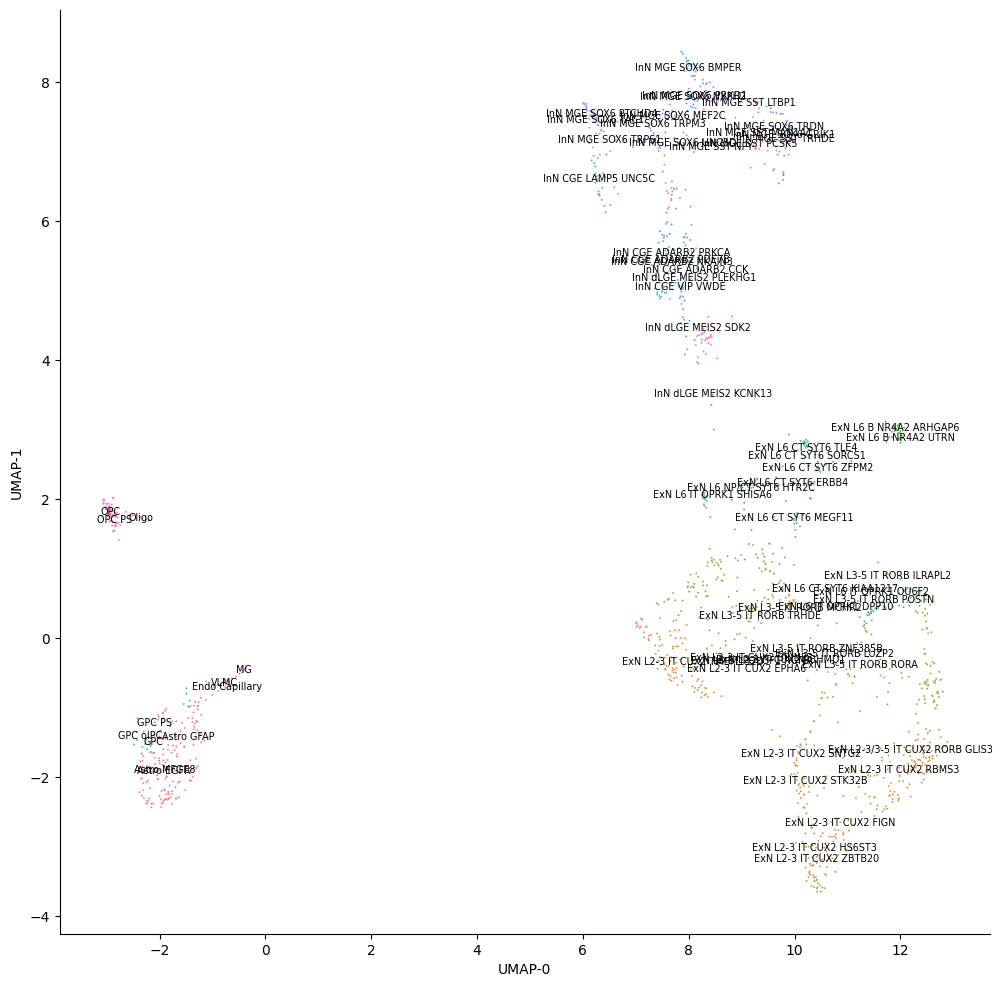

In [ ]:
# Plot observed
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(sim_data_embed, x='UMAP-0', y='UMAP-1', hue='subtype', s=2, legend=False, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = sim_data_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

### CellTRIP

In [ ]:
# Reduce CellTRIP
steady_state_gex_embed = red.transform(steady_state_gex)  # np.concat([sim_data, steady_state_gex], axis=0)
steady_state_gex_embed = pd.DataFrame(steady_state_gex_embed, index=adata.obs_names, columns=[f'UMAP-{i}' for i in range(steady_state_gex_embed.shape[1])])
steady_state_gex_embed['subtype'] = adata.obs['subtype']
steady_state_gex_embed['sample'] = adata.obs['sample']
steady_state_gex_embed['source'] = 'CellTRIP'

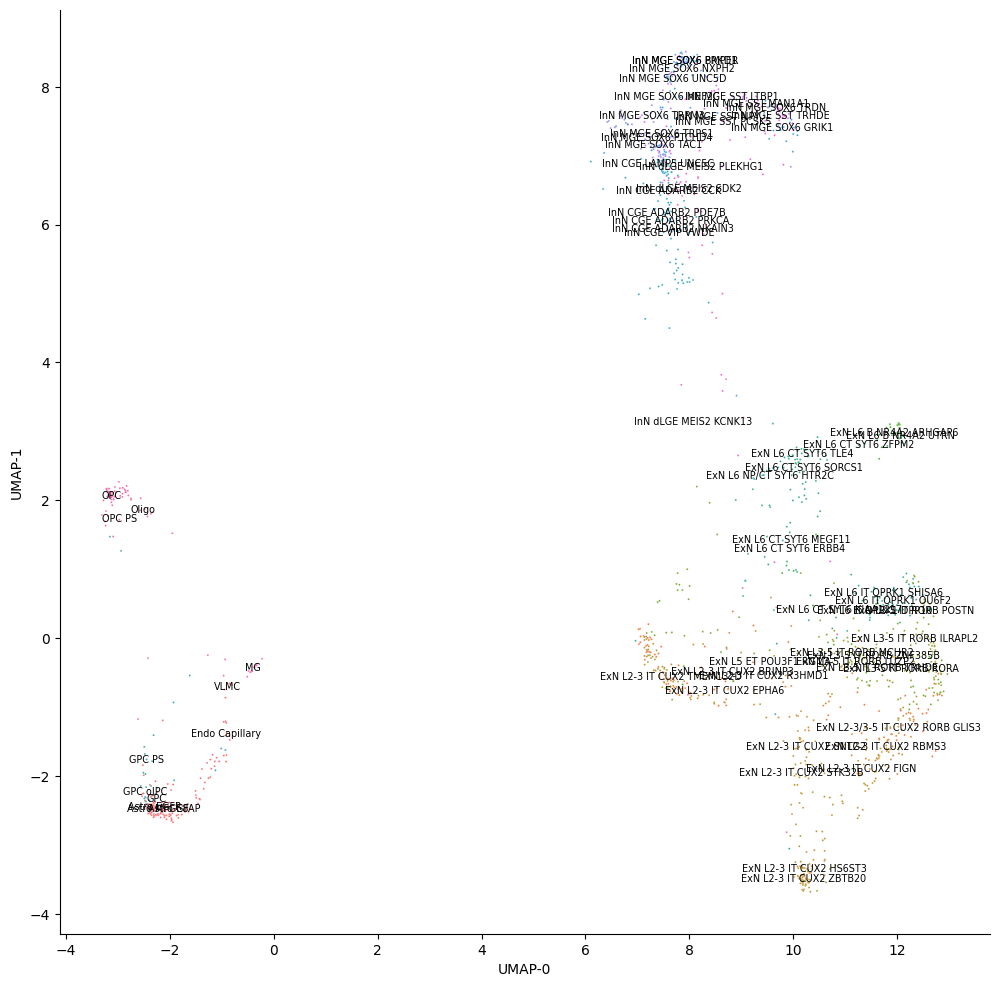

In [ ]:
# Plot CellTRIP
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(steady_state_gex_embed, x='UMAP-0', y='UMAP-1', hue='subtype', s=2, legend=False, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = steady_state_gex_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

### Training and validation

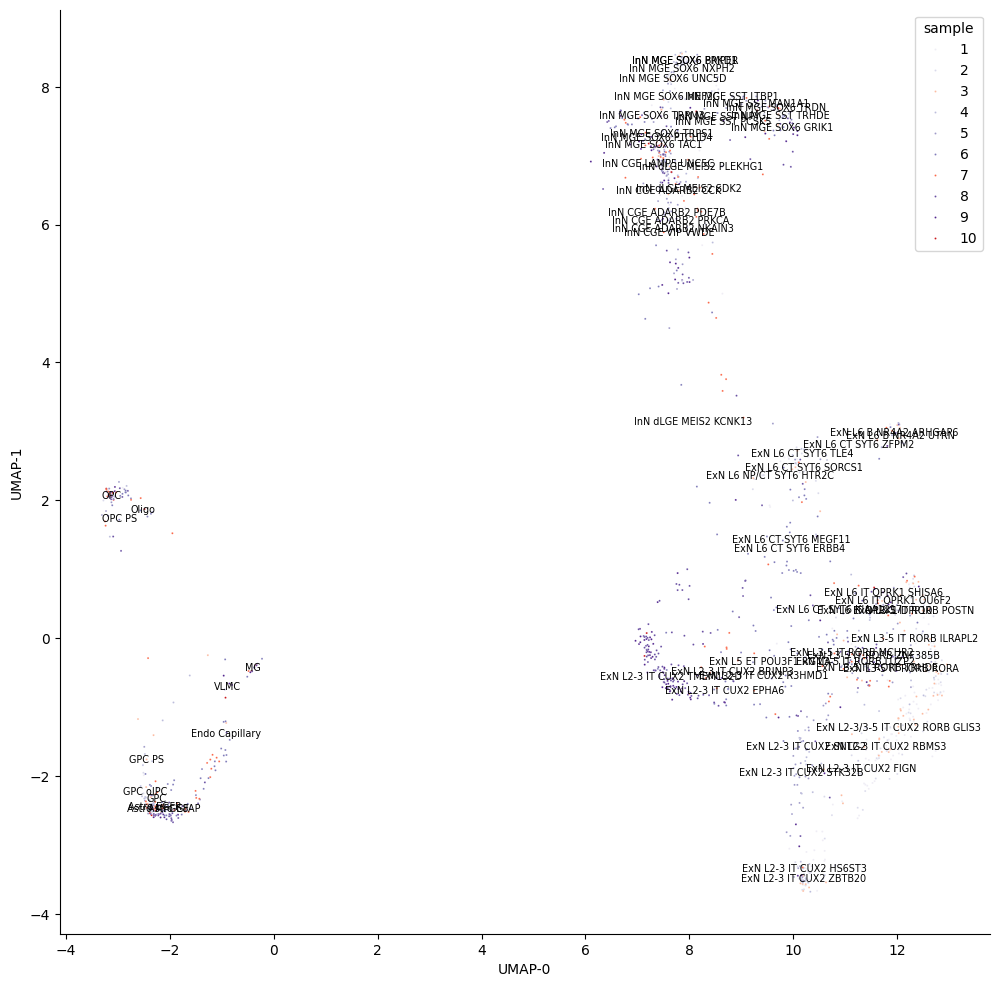

In [ ]:
# Get colors
sample_train = adata.obs.groupby('sample')['Train'].max()
hue_order = sample_train.index.to_numpy()
palette = np.zeros((sample_train.shape[0], 3))
palette[sample_train] = sns.color_palette('Purples', sample_train.sum())
palette[~sample_train] = sns.color_palette('Reds', (~sample_train).sum())
# palette[:] = sns.color_palette('Purples', sample_train.shape[0])
palette = palette.tolist()
# Plot CellTRIP samples
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(steady_state_gex_embed, x='UMAP-0', y='UMAP-1', hue='sample', hue_order=hue_order, palette=palette, s=2, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = steady_state_gex_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

### Observed and CellTRIP

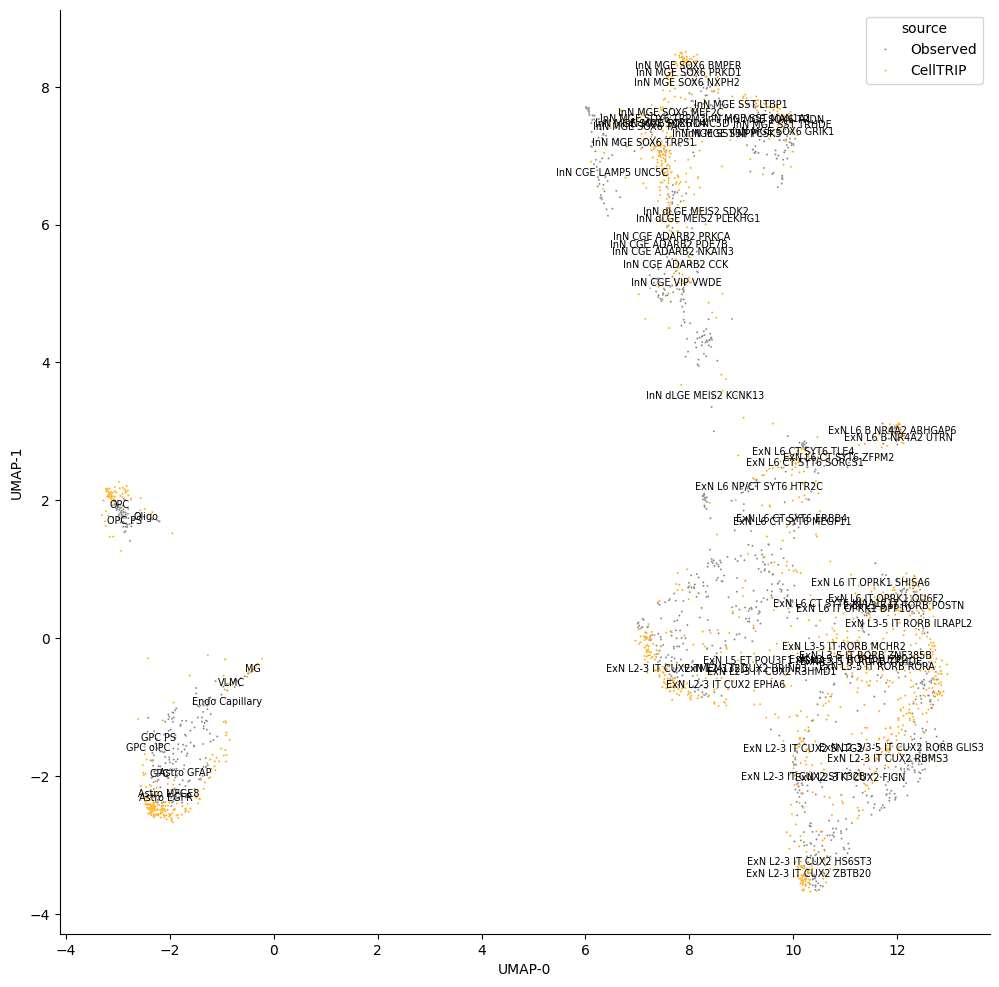

In [ ]:
# Concatenate
concat_embed = pd.concat([sim_data_embed, steady_state_gex_embed], axis=0)

# Plot observed vs. CellTRIP
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(concat_embed, x='UMAP-0', y='UMAP-1', hue='source', palette=['gray', 'orange'], s=2, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = concat_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

# Knock Down *RAPGEF4*

In [5]:
# Knockdown for select genes
genes_to_perturb = (
    'Control',
    'RAPGEF4', 'CHD8',  # Experimental genes for neuronal maturation
    'MEIS2', 'NFIA', 'NFIB',  # Known TFs for neuronal maturation
)
knocked_state_gex = {'Steady': manager.get_state()[0]}
for gene in genes_to_perturb:
    # Simulate perturbation
    if gene != 'Control':
        manager.add_perturbation([gene], modality=0, feature_targets=0)
    time, states = manager.simulate_perturbation(skip_time=512., time=128.)
    knocked_state_gex[gene] = states[0][-1]
    
    # Revert to previous state
    manager.load_state('steady')
    manager.clear_perturbations()

100%|██████████| 1280/1280 [00:27<00:00, 45.94it/s]


In [23]:
# Generate effect size heatmap
subtype_effects = pd.DataFrame()
for gene in genes_to_perturb:
    if gene == 'Steady': continue
    gene_diff = pd.DataFrame(index=adata.obs_names)
    gene_diff['Distance'] = np.sqrt(np.square(knocked_state_gex[gene] - knocked_state_gex['Steady']).mean(axis=1))
    gene_diff['Subtype'] = adata.obs['subtype']
    gene_diff['Age'] = adata.obs['age']
    gene_diff['Identifier'] = gene_diff.apply(lambda r: f'{r["Subtype"]} - {r["Age"]}', axis=1)
    gene_subtype_diff = gene_diff.groupby('Identifier', observed=True)[['Distance']].mean().reset_index()
    gene_subtype_diff['Gene'] = gene
    subtype_effects = pd.concat([subtype_effects, gene_subtype_diff])

# Format
subtype_effects = subtype_effects.pivot(index='Identifier', columns='Gene', values='Distance')
subtype_effects = subtype_effects[list(genes_to_perturb)]

# Change to log-fold change vs. control
# subtype_effects = np.exp(
#     np.log(subtype_effects.drop(columns='Control'))
#     - np.log(subtype_effects['Control']).to_numpy().reshape((-1, 1)))
subtype_effects = subtype_effects.drop(columns='Control')

## Visualize

### Shift for *MEIS2*

In [ ]:
# Reduce knocked
chosen_gene = 'MEIS2'
knocked_state_gex_embed = red.transform(knocked_state_gex[chosen_gene])
knocked_state_gex_embed = pd.DataFrame(knocked_state_gex_embed, index=adata.obs_names, columns=[f'UMAP-{i}' for i in range(knocked_state_gex_embed.shape[1])])
knocked_state_gex_embed['subtype'] = adata.obs['subtype']
knocked_state_gex_embed['sample'] = adata.obs['sample']
knocked_state_gex_embed['source'] = 'CellTRIP Knockdown'

In [ ]:
# # Plot CellTRIP knockdown
# fig, ax = plt.subplots(figsize=(12, 12))
# sns.scatterplot(knocked_state_gex_embed, x='UMAP-0', y='UMAP-1', hue='subtype', s=2, legend=False, ax=ax)
# sns.despine(ax=ax)
# # Annotate
# subtype_means = knocked_state_gex_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
# for subtype, r in subtype_means.iterrows():
#     ax.text(*r.to_numpy(), subtype, ha='center', va='center', fontsize='x-small', transform=ax.transData)

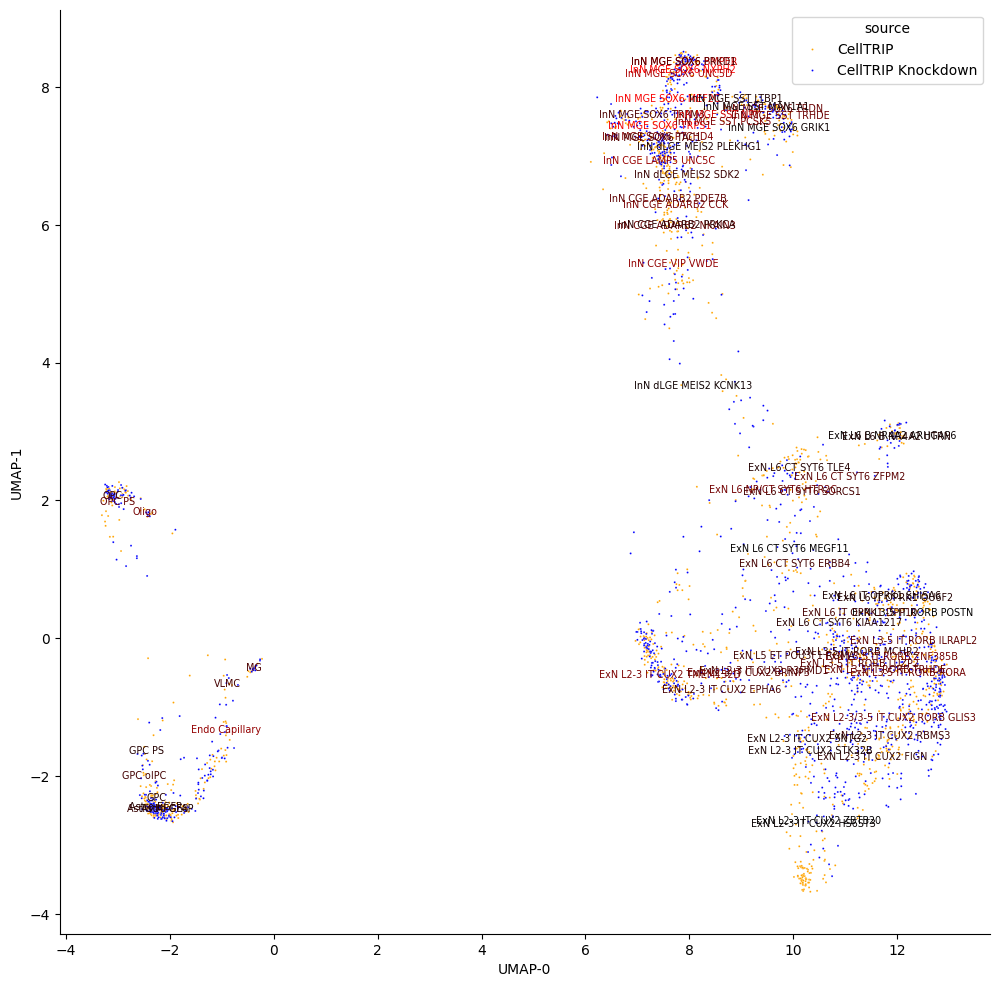

In [ ]:
# Get mean subtype deviation
fold_change = subtype_effects[chosen_gene]
alpha = np.abs(fold_change - 1)
alpha /= alpha.max()

# Concatenate
concat_embed = pd.concat([steady_state_gex_embed, knocked_state_gex_embed], axis=0)

# Plot CellTRIP vs. CellTRIP knockdown
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(concat_embed, x='UMAP-0', y='UMAP-1', hue='source', palette=['orange', 'blue'], s=2, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
subtype_means = concat_embed.groupby('subtype', observed=True)[['UMAP-0', 'UMAP-1']].median()
for subtype, r in subtype_means.iterrows():
    ax.text(
        *r.to_numpy(), subtype,
        ha='center', va='center', fontsize='x-small',
        color=[alpha.loc[subtype], 0, 0],
        transform=ax.transData)

### Heatmap of gene effects

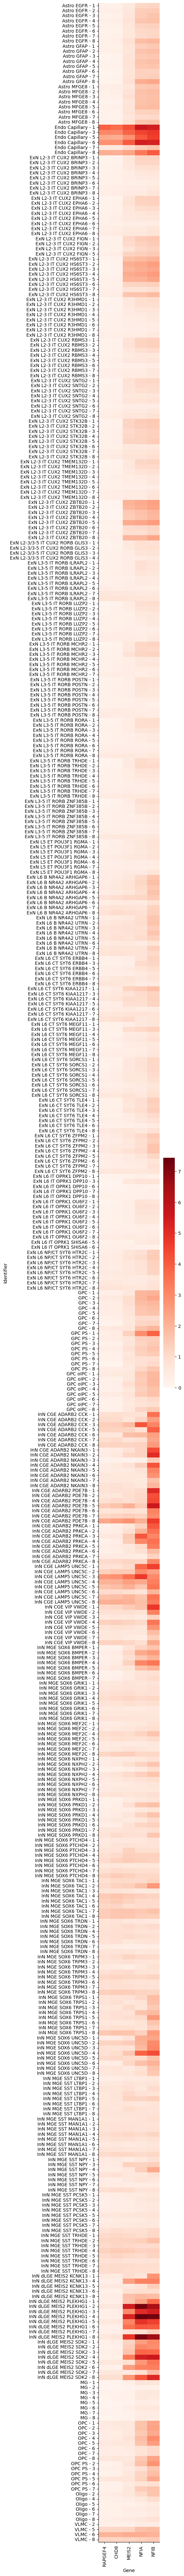

In [32]:
# Normalized
fig, ax = plt.subplots(figsize=(3, 100))
sns.heatmap(subtype_effects, cmap='Reds', vmin=0, ax=ax)  # Unnormalized
# centered = subtype_effects - 1
# df = centered / centered.to_numpy().std(keepdims=True, axis=0) + 1
# sns.heatmap(df, cmap='viridis', vmin=0, vmax=2, ax=ax)  # Normalized
sns.despine(ax=ax)